In [59]:

# === PASO 1: IMPORTACIÓN DE LIBRERÍAS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import joblib

# Configuración
pd.set_option('display.max_columns', 100)
np.random.seed(42)
tf.random.set_seed(42)
sns.set_style("whitegrid")




In [60]:


# === PASO 2: CARGA Y EXPLORACIÓN INICIAL ===

df = pd.read_csv('train.csv')
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head(3))

# Análisis de valores faltantes
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nValores faltantes por columna:")
print(missing)

# Distribución de la variable objetivo
plt.figure(figsize=(12, 6))
sns.histplot(df['SalePrice'], kde=True, color='darkblue')
plt.title('Distribución de Precios de Venta', fontsize=14)
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [61]:


# %% [code]
# === PASO 3: PREPROCESAMIENTO AVANZADO ===

# Identificación de tipos de variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(exclude=['object']).columns.drop('SalePrice').tolist()

# Feature Engineering Estratégico
def advanced_feature_engineering(df):
    df = df.copy()
    
    # 1. Relación entre áreas
    df['LivingAreaRatio'] = df['GrLivArea'] / (df['TotalBsmtSF'] + 1)
    df['RoomDensity'] = df['TotRmsAbvGrd'] / (df['GrLivArea'] + 1)
    
    # 2. Antigüedad y renovaciones
    current_year = 2025  # Actualizar según necesidad
    df['HouseAge'] = current_year - df['YearBuilt']
    df['SinceRemodel'] = current_year - df['YearRemodAdd']
    
    # 3. Calidad compuesta
    df['OverallGrade'] = df['OverallQual'] * df['OverallCond']
    df['ExterGrade'] = df['ExterQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}) * \
                      df['ExterCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
    
    # 4. Características del garage
    df['GarageScore'] = df['GarageCars'] * df['GarageArea']
    
    # 5. Codificación ordinal manual
    qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
    df['KitchenQualScore'] = df['KitchenQual'].map(qual_dict)
    df['FireplaceScore'] = df['FireplaceQu'].map(qual_dict).fillna(0)
    
    # 6. Interacciones importantes
    df['Qual_LivArea'] = df['OverallQual'] * df['GrLivArea']
    df['Qual_Year'] = df['OverallQual'] * df['YearBuilt']
    
    # 7. Simplificación de categorías
    df['SimplifiedNeighborhood'] = df['Neighborhood'].apply(
        lambda x: 'Premium' if x in ['NridgHt', 'StoneBr', 'NoRidge'] else 'Standard')
    
    return df

df_engineered = advanced_feature_engineering(df)

# Actualizamos listas de columnas
categorical_cols = df_engineered.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_engineered.select_dtypes(exclude=['object']).columns.drop('SalePrice').tolist()





In [62]:
# %% [code]
# === PASO 4: PIPELINE DE PREPROCESAMIENTO ===

# Escalado correcto de las características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Escalado estándar
])

# Codificación adecuada para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Aplicación del preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# División de datos
X = df_engineered.drop('SalePrice', axis=1)
y = np.log1p(df_engineered['SalePrice'])  # Transformación logarítmica

# Versión mejorada con shuffling controlado
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.15, 
    shuffle=True,  # Activamos shuffling explícitamente
    random_state=42  # Semilla para reproducibilidad
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2, 
    shuffle=True,  # Shuffling también en esta división
    random_state=42  # Misma semilla para consistencia
)


# Aplicamos preprocesamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Obtenemos nombres de características
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(cat_features)

# Selección de características (top 50)
selector = SelectKBest(f_regression, k=50)
X_train_selected = selector.fit_transform(X_train_preprocessed, y_train)
X_val_selected = selector.transform(X_val_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)



In [63]:


# %% [code]
# === PASO 5: CONSTRUCCIÓN DE LA RED NEURONAL ===

def build_advanced_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu',
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu',
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.005, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model = build_advanced_model(X_train_selected.shape[1])
model.summary()



c:\Users\Alumno_AI\.conda\envs\house\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,241 (227.50 KB)

 Trainable params: 57,281 (223.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/500


19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 143.1588 - mae: 11.8897 

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 140.0079 - mae: 11.7650 - val_loss: 111.9147 - val_mae: 10.5627 - learning_rate: 0.0050
Epoch 2/500
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 109.4045 - mae: 10.4015 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 104.1726 - mae: 10.1339 - val_loss: 59.6017 - val_mae: 7.6828 - learning_rate: 0.0050
Epoch 3/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.7676 - mae: 7.3573 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 49.0809 - mae: 6.8301 - val_loss: 14.0246 - val_mae: 3.6780 - learning_rate: 0.0050
Epoch 4/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8235 - mae: 2.7573  

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7059 - mae: 2.3199 - val_loss: 0.9329 - val_mae: 0.7524 - learning_rate: 0.0050
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0875 - mae: 1.1028 - val_loss: 1.0276 - val_mae: 0.6612 - learning_rate: 0.0050
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7301 - mae: 0.9732 - val_loss: 1.1266 - val_mae: 0.8468 - learning_rate: 0.0050
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4228 - mae: 0.8840 - val_loss: 1.2307 - val_mae: 0.6234 - learning_rate: 0.0050
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4853 - mae: 0.9024 - val_loss: 1.6695 - val_mae: 0.8959 - learning_rate: 0.0050
Epoch 9/500
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2234 - mae: 0.8288 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2005 - mae: 0.8162 - val_loss: 0.5568 - val_mae: 0.5233 - learning_rate: 0.0050
Epoch 10/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2605 - mae: 0.7918

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2576 - mae: 0.7915 - val_loss: 0.5326 - val_mae: 0.4599 - learning_rate: 0.0050
Epoch 11/500
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9737 - mae: 0.7091

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9816 - mae: 0.7120 - val_loss: 0.2315 - val_mae: 0.2478 - learning_rate: 0.0050
Epoch 12/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0448 - mae: 0.7438 - val_loss: 0.8037 - val_mae: 0.4658 - learning_rate: 0.0050
Epoch 13/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0200 - mae: 0.7179 - val_loss: 0.2448 - val_mae: 0.2710 - learning_rate: 0.0050
Epoch 14/500
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9246 - mae: 0.6944 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9112 - mae: 0.6907 - val_loss: 0.1522 - val_mae: 0.1566 - learning_rate: 0.0050
Epoch 15/500
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9433 - mae: 0.6919 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9079 - mae: 0.6818 - val_loss: 0.1458 - val_mae: 0.1428 - learning_rate: 0.0050
Epoch 16/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8447 - mae: 0.6722 - val_loss: 0.1902 - val_mae: 0.1836 - learning_rate: 0.0050
Epoch 17/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7843 - mae: 0.6575 - val_loss: 0.1684 - val_mae: 0.1827 - learning_rate: 0.0050
Epoch 18/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7748 - mae: 0.6276 - val_loss: 0.2048 - val_mae: 0.2052 - learning_rate: 0.0050
Epoch 19/500
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6615 - mae: 0.5848 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6745 - mae: 0.5922 - val_loss: 0.1323 - val_mae: 0.1232 - learning_rate: 0.0050
Epoch 20/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7075 - mae: 0.6173 - val_loss: 0.1331 - val_mae: 0.1312 - learning_rate: 0.0050
Epoch 21/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7378 - mae: 0.6252 - val_loss: 0.1360 - val_mae: 0.1373 - learning_rate: 0.0050
Epoch 22/500
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7185 - mae: 0.6109 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6887 - mae: 0.5983 - val_loss: 0.1282 - val_mae: 0.1244 - learning_rate: 0.0050
Epoch 23/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6573 - mae: 0.6028 - val_loss: 0.1502 - val_mae: 0.1882 - learning_rate: 0.0050
Epoch 24/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6863 - mae: 0.5916 - val_loss: 0.1748 - val_mae: 0.2387 - learning_rate: 0.0050
Epoch 25/500
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7429 - mae: 0.6279

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7316 - mae: 0.6229 - val_loss: 0.1228 - val_mae: 0.1225 - learning_rate: 0.0050
Epoch 26/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6293 - mae: 0.5740 - val_loss: 0.1399 - val_mae: 0.1735 - learning_rate: 0.0050
Epoch 27/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5827 - mae: 0.5620 - val_loss: 0.1416 - val_mae: 0.1831 - learning_rate: 0.0050
Epoch 28/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6180 - mae: 0.5782 - val_loss: 0.1259 - val_mae: 0.1455 - learning_rate: 0.0050
Epoch 29/500
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6927 - mae: 0.6140 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6677 - mae: 0.5975 - val_loss: 0.1124 - val_mae: 0.1141 - learning_rate: 0.0050
Epoch 30/500
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5317 - mae: 0.5030 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5421 - mae: 0.5186 - val_loss: 0.1108 - val_mae: 0.1162 - learning_rate: 0.0050
Epoch 31/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5829 - mae: 0.5606 - val_loss: 0.1182 - val_mae: 0.1387 - learning_rate: 0.0050
Epoch 32/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5742 - mae: 0.5556 - val_loss: 0.1310 - val_mae: 0.1636 - learning_rate: 0.0050
Epoch 33/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6434 - mae: 0.5857 - val_loss: 0.1417 - val_mae: 0.2076 - learning_rate: 0.0050
Epoch 34/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5218 - mae: 0.5381 - val_loss: 0.1175 - val_mae: 0.1459 - learning_rate: 0.0050
Epoch 35/500
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5132 - mae: 0.5225 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5118 - mae: 0.5214 - val_loss: 0.1064 - val_mae: 0.1266 - learning_rate: 0.0050
Epoch 36/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5280 - mae: 0.5331 - val_loss: 0.1142 - val_mae: 0.1466 - learning_rate: 0.0050
Epoch 37/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5150 - mae: 0.5333

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5146 - mae: 0.5330 - val_loss: 0.1025 - val_mae: 0.1276 - learning_rate: 0.0050
Epoch 38/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5034 - mae: 0.5243 - val_loss: 0.1079 - val_mae: 0.1456 - learning_rate: 0.0050
Epoch 39/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5420 - mae: 0.5520 - val_loss: 0.1218 - val_mae: 0.1872 - learning_rate: 0.0050
Epoch 40/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5831 - mae: 0.5664 - val_loss: 0.1147 - val_mae: 0.1686 - learning_rate: 0.0050
Epoch 41/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4482 - mae: 0.4922 - val_loss: 0.1097 - val_mae: 0.1639 - learning_rate: 0.0050
Epoch 42/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5304 - mae: 0.5349 - val_loss: 0.1278 - val_mae: 0.2078 - learning_rate: 0.0050
Epoch 43/500
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5066 - mae: 0.5387

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5078 - mae: 0.5378 - val_loss: 0.0861 - val_mae: 0.1091 - learning_rate: 0.0050
Epoch 44/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5421 - mae: 0.5511 - val_loss: 0.1116 - val_mae: 0.1670 - learning_rate: 0.0050
Epoch 45/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5544 - mae: 0.5511 - val_loss: 0.0924 - val_mae: 0.1345 - learning_rate: 0.0050
Epoch 46/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5337 - mae: 0.5432 - val_loss: 0.1054 - val_mae: 0.1737 - learning_rate: 0.0050
Epoch 47/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4971 - mae: 0.5241 - val_loss: 0.0985 - val_mae: 0.1597 - learning_rate: 0.0050
Epoch 48/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4527 - mae: 0.4893 - val_loss: 0.1252 - val_mae: 0.2205 - learning_rate: 0.0050
Epoch 49/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5020 - mae: 0.5360 - val_loss: 0.1123 - val_mae: 0.1772 - learning_rate: 0.0050
Epoch 50/500
19/31

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4389 - mae: 0.4949 - val_loss: 0.0780 - val_mae: 0.1155 - learning_rate: 0.0050
Epoch 51/500
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4420 - mae: 0.4971

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4423 - mae: 0.4971 - val_loss: 0.0774 - val_mae: 0.1156 - learning_rate: 0.0050
Epoch 52/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4597 - mae: 0.5012 - val_loss: 0.0803 - val_mae: 0.1318 - learning_rate: 0.0050
Epoch 53/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4311 - mae: 0.4934 - val_loss: 0.0907 - val_mae: 0.1606 - learning_rate: 0.0050
Epoch 54/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4811 - mae: 0.5101 - val_loss: 0.1128 - val_mae: 0.2163 - learning_rate: 0.0050
Epoch 55/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4804 - mae: 0.5245 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4841 - mae: 0.5273 - val_loss: 0.0718 - val_mae: 0.1104 - learning_rate: 0.0050
Epoch 56/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4290 - mae: 0.4951 - val_loss: 0.0881 - val_mae: 0.1592 - learning_rate: 0.0050
Epoch 57/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5111 - mae: 0.5354 - val_loss: 0.0894 - val_mae: 0.1684 - learning_rate: 0.0050
Epoch 58/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4286 - mae: 0.4900 - val_loss: 0.0736 - val_mae: 0.1288 - learning_rate: 0.0050
Epoch 59/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3654 - mae: 0.4509 - val_loss: 0.0756 - val_mae: 0.1370 - learning_rate: 0.0050
Epoch 60/500
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4401 - mae: 0.5078 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4322 - mae: 0.4994 - val_loss: 0.0695 - val_mae: 0.1174 - learning_rate: 0.0050
Epoch 61/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4433 - mae: 0.4903 - val_loss: 0.0973 - val_mae: 0.1978 - learning_rate: 0.0050
Epoch 62/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5225 - mae: 0.5553 - val_loss: 0.0780 - val_mae: 0.1444 - learning_rate: 0.0050
Epoch 63/500
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4498 - mae: 0.5085 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4469 - mae: 0.5031 - val_loss: 0.0676 - val_mae: 0.1204 - learning_rate: 0.0050
Epoch 64/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3688 - mae: 0.4508 - val_loss: 0.0739 - val_mae: 0.1451 - learning_rate: 0.0050
Epoch 65/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4566 - mae: 0.5104 - val_loss: 0.0822 - val_mae: 0.1714 - learning_rate: 0.0050
Epoch 66/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4106 - mae: 0.4925 - val_loss: 0.0855 - val_mae: 0.1741 - learning_rate: 0.0050
Epoch 67/500
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3875 - mae: 0.4735

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3871 - mae: 0.4734 - val_loss: 0.0641 - val_mae: 0.1214 - learning_rate: 0.0050
Epoch 68/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4343 - mae: 0.5025 - val_loss: 0.0742 - val_mae: 0.1542 - learning_rate: 0.0050
Epoch 69/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4052 - mae: 0.4869 - val_loss: 0.0826 - val_mae: 0.1780 - learning_rate: 0.0050
Epoch 70/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4308 - mae: 0.5112 - val_loss: 0.0708 - val_mae: 0.1421 - learning_rate: 0.0050
Epoch 71/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4246 - mae: 0.4939 - val_loss: 0.0709 - val_mae: 0.1470 - learning_rate: 0.0050
Epoch 72/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3978 - mae: 0.4824 - val_loss: 0.0691 - val_mae: 0.1457 - learning_rate: 0.0050
Epoch 73/500
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4051 - mae: 0.4868 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3997 - mae: 0.4811 - val_loss: 0.0587 - val_mae: 0.1165 - learning_rate: 0.0050
Epoch 74/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3915 - mae: 0.4825 - val_loss: 0.0607 - val_mae: 0.1256 - learning_rate: 0.0050
Epoch 75/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4008 - mae: 0.4895 - val_loss: 0.0625 - val_mae: 0.1293 - learning_rate: 0.0050
Epoch 76/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3854 - mae: 0.4785 - val_loss: 0.0694 - val_mae: 0.1558 - learning_rate: 0.0050
Epoch 77/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3776 - mae: 0.4684 - val_loss: 0.0655 - val_mae: 0.1472 - learning_rate: 0.0050
Epoch 78/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3460 - mae: 0.4470 - val_loss: 0.0868 - val_mae: 0.2004 - learning_rate: 0.0050
Epoch 79/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3507 - mae: 0.4634 - val_loss: 0.0734 - val_mae: 0.1676 - learning_rate: 0.0050
Epoch 80/500
31/31 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3825 - mae: 0.4688 - val_loss: 0.0514 - val_mae: 0.1102 - learning_rate: 0.0025
Epoch 85/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3419 - mae: 0.4516 - val_loss: 0.0521 - val_mae: 0.1144 - learning_rate: 0.0025
Epoch 86/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3207 - mae: 0.4290 - val_loss: 0.0570 - val_mae: 0.1273 - learning_rate: 0.0025
Epoch 87/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3310 - mae: 0.4320 - val_loss: 0.0608 - val_mae: 0.1462 - learning_rate: 0.0025
Epoch 88/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2992 - mae: 0.4245 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3166 - mae: 0.4350 - val_loss: 0.0511 - val_mae: 0.1154 - learning_rate: 0.0025
Epoch 89/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4087 - mae: 0.5051 - val_loss: 0.0587 - val_mae: 0.1375 - learning_rate: 0.0025
Epoch 90/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3484 - mae: 0.4594 - val_loss: 0.0532 - val_mae: 0.1236 - learning_rate: 0.0025
Epoch 91/500
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3520 - mae: 0.4638

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3573 - mae: 0.4666 - val_loss: 0.0489 - val_mae: 0.1150 - learning_rate: 0.0025
Epoch 92/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3430 - mae: 0.4474 - val_loss: 0.0496 - val_mae: 0.1147 - learning_rate: 0.0025
Epoch 93/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3502 - mae: 0.4554 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3531 - mae: 0.4578 - val_loss: 0.0488 - val_mae: 0.1138 - learning_rate: 0.0025
Epoch 94/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3474 - mae: 0.4565 - val_loss: 0.0534 - val_mae: 0.1284 - learning_rate: 0.0025
Epoch 95/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3431 - mae: 0.4574 - val_loss: 0.0561 - val_mae: 0.1383 - learning_rate: 0.0025
Epoch 96/500
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3794 - mae: 0.4815 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3665 - mae: 0.4701 - val_loss: 0.0474 - val_mae: 0.1133 - learning_rate: 0.0025
Epoch 97/500
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3560 - mae: 0.4528

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3576 - mae: 0.4533 - val_loss: 0.0424 - val_mae: 0.0990 - learning_rate: 0.0025
Epoch 98/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3392 - mae: 0.4454 - val_loss: 0.0547 - val_mae: 0.1359 - learning_rate: 0.0025
Epoch 99/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3518 - mae: 0.4557 - val_loss: 0.0494 - val_mae: 0.1240 - learning_rate: 0.0025
Epoch 100/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3360 - mae: 0.4530

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3360 - mae: 0.4530 - val_loss: 0.0423 - val_mae: 0.1010 - learning_rate: 0.0025
Epoch 101/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3080 - mae: 0.4274 - val_loss: 0.0498 - val_mae: 0.1223 - learning_rate: 0.0025
Epoch 102/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3383 - mae: 0.4404 - val_loss: 0.0534 - val_mae: 0.1325 - learning_rate: 0.0025
Epoch 103/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3146 - mae: 0.4228 - val_loss: 0.0493 - val_mae: 0.1212 - learning_rate: 0.0025
Epoch 104/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3138 - mae: 0.4241 - val_loss: 0.0424 - val_mae: 0.1051 - learning_rate: 0.0025
Epoch 105/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3274 - mae: 0.4329 - val_loss: 0.0508 - val_mae: 0.1279 - learning_rate: 0.0025
Epoch 106/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3103 - mae: 0.4236 - val_loss: 0.0508 - val_mae: 0.1320 - learning_rate: 0.0025
Epoch 107/500

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3152 - mae: 0.4376 - val_loss: 0.0407 - val_mae: 0.1038 - learning_rate: 0.0012
Epoch 110/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3209 - mae: 0.4457 - val_loss: 0.0479 - val_mae: 0.1258 - learning_rate: 0.0012
Epoch 111/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2957 - mae: 0.4189 - val_loss: 0.0451 - val_mae: 0.1183 - learning_rate: 0.0012
Epoch 112/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3332 - mae: 0.4347 - val_loss: 0.0408 - val_mae: 0.1061 - learning_rate: 0.0012
Epoch 113/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3198 - mae: 0.4365 - val_loss: 0.0467 - val_mae: 0.1233 - learning_rate: 0.0012
Epoch 114/500
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3200 - mae: 0.4401 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3220 - mae: 0.4408 - val_loss: 0.0395 - val_mae: 0.1034 - learning_rate: 0.0012
Epoch 115/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3366 - mae: 0.4523 - val_loss: 0.0448 - val_mae: 0.1216 - learning_rate: 0.0012
Epoch 116/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2853 - mae: 0.4057 - val_loss: 0.0508 - val_mae: 0.1415 - learning_rate: 0.0012
Epoch 117/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3296 - mae: 0.4375 - val_loss: 0.0396 - val_mae: 0.1091 - learning_rate: 0.0012
Epoch 118/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3092 - mae: 0.4205 - val_loss: 0.0441 - val_mae: 0.1229 - learning_rate: 0.0012
Epoch 119/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3227 - mae: 0.4384 - val_loss: 0.0479 - val_mae: 0.1336 - learning_rate: 0.0012
Epoch 120/500
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3609 - mae: 0.4606 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3532 - mae: 0.4571 - val_loss: 0.0377 - val_mae: 0.1027 - learning_rate: 0.0012
Epoch 121/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2923 - mae: 0.4150 - val_loss: 0.0463 - val_mae: 0.1271 - learning_rate: 0.0012
Epoch 122/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3218 - mae: 0.4399 - val_loss: 0.0398 - val_mae: 0.1130 - learning_rate: 0.0012
Epoch 123/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3031 - mae: 0.4271 - val_loss: 0.0515 - val_mae: 0.1408 - learning_rate: 0.0012
Epoch 124/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3134 - mae: 0.4303 - val_loss: 0.0430 - val_mae: 0.1205 - learning_rate: 0.0012
Epoch 125/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3238 - mae: 0.4419 - val_loss: 0.0428 - val_mae: 0.1210 - learning_rate: 0.0012
Epoch 126/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3355 - mae: 0.4433 - val_loss: 0.0458 - val_mae: 0.1273 - learning_rate: 0.0012
Epoch 127/500

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2616 - mae: 0.4039 - val_loss: 0.0344 - val_mae: 0.1009 - learning_rate: 6.2500e-04
Epoch 140/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3255 - mae: 0.4529 - val_loss: 0.0499 - val_mae: 0.1477 - learning_rate: 6.2500e-04
Epoch 141/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3048 - mae: 0.4252 - val_loss: 0.0366 - val_mae: 0.1086 - learning_rate: 6.2500e-04
Epoch 142/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2984 - mae: 0.4261 - val_loss: 0.0354 - val_mae: 0.1040 - learning_rate: 6.2500e-04
Epoch 143/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2911 - mae: 0.4134 - val_loss: 0.0380 - val_mae: 0.1142 - learning_rate: 6.2500e-04
Epoch 144/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3190 - mae: 0.4420 - val_loss: 0.0349 - val_mae: 0.1068 - learning_rate: 6.2500e-04
Epoch 145/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2947 - mae: 0.4213 - val_loss: 0.0392 - val_mae: 0.1215 - learning_ra

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2980 - mae: 0.4229 - val_loss: 0.0341 - val_mae: 0.1046 - learning_rate: 3.1250e-04
Epoch 152/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3133 - mae: 0.4330 - val_loss: 0.0375 - val_mae: 0.1167 - learning_rate: 3.1250e-04
Epoch 153/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2646 - mae: 0.3945 - val_loss: 0.0374 - val_mae: 0.1180 - learning_rate: 3.1250e-04
Epoch 154/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2952 - mae: 0.4100 - val_loss: 0.0350 - val_mae: 0.1101 - learning_rate: 3.1250e-04
Epoch 155/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2891 - mae: 0.4152 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2947 - mae: 0.4184 - val_loss: 0.0331 - val_mae: 0.1016 - learning_rate: 3.1250e-04
Epoch 156/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3131 - mae: 0.4372 - val_loss: 0.0379 - val_mae: 0.1185 - learning_rate: 3.1250e-04
Epoch 157/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3089 - mae: 0.4303 - val_loss: 0.0353 - val_mae: 0.1088 - learning_rate: 3.1250e-04
Epoch 158/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2860 - mae: 0.4126 - val_loss: 0.0337 - val_mae: 0.1045 - learning_rate: 3.1250e-04
Epoch 159/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2509 - mae: 0.3802 - val_loss: 0.0346 - val_mae: 0.1074 - learning_rate: 3.1250e-04
Epoch 160/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2953 - mae: 0.4298 - val_loss: 0.0405 - val_mae: 0.1235 - learning_rate: 3.1250e-04
Epoch 161/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2919 - mae: 0.4128 - val_loss: 0.0378 - val_mae: 0.1180 - learning_ra

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2733 - mae: 0.3999 - val_loss: 0.0328 - val_mae: 0.1041 - learning_rate: 1.5625e-04
Epoch 168/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2924 - mae: 0.4194 - val_loss: 0.0336 - val_mae: 0.1066 - learning_rate: 1.5625e-04
Epoch 169/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2752 - mae: 0.4128 - val_loss: 0.0349 - val_mae: 0.1112 - learning_rate: 1.5625e-04
Epoch 170/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2707 - mae: 0.4036 - val_loss: 0.0337 - val_mae: 0.1077 - learning_rate: 1.5625e-04
Epoch 171/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2801 - mae: 0.4148 - val_loss: 0.0383 - val_mae: 0.1227 - learning_rate: 1.5625e-04
Epoch 172/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2723 - mae: 0.4068 - val_loss: 0.0357 - val_mae: 0.1152 - learning_rate: 1.5625e-04
Epoch 173/500
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2848 - mae: 0.4203 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2938 - mae: 0.4265 - val_loss: 0.0314 - val_mae: 0.1004 - learning_rate: 1.5625e-04
Epoch 174/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2840 - mae: 0.4091 - val_loss: 0.0346 - val_mae: 0.1112 - learning_rate: 1.5625e-04
Epoch 175/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2944 - mae: 0.4139 - val_loss: 0.0360 - val_mae: 0.1158 - learning_rate: 1.5625e-04
Epoch 176/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2508 - mae: 0.3865 - val_loss: 0.0331 - val_mae: 0.1071 - learning_rate: 1.5625e-04
Epoch 177/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2874 - mae: 0.4115 - val_loss: 0.0344 - val_mae: 0.1121 - learning_rate: 1.5625e-04
Epoch 178/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2974 - mae: 0.4244 - val_loss: 0.0334 - val_mae: 0.1092 - learning_rate: 1.5625e-04
Epoch 179/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2619 - mae: 0.3992 - val_loss: 0.0371 - val_mae: 0.1213 - learning_ra

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2732 - mae: 0.4072 - val_loss: 0.0305 - val_mae: 0.0999 - learning_rate: 7.8125e-05
Epoch 192/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3070 - mae: 0.4336 - val_loss: 0.0317 - val_mae: 0.1046 - learning_rate: 7.8125e-05
Epoch 193/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2750 - mae: 0.4171 - val_loss: 0.0316 - val_mae: 0.1043 - learning_rate: 7.8125e-05
Epoch 194/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2773 - mae: 0.4147 - val_loss: 0.0321 - val_mae: 0.1062 - learning_rate: 7.8125e-05
Epoch 195/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2977 - mae: 0.4263 - val_loss: 0.0340 - val_mae: 0.1121 - learning_rate: 7.8125e-05
Epoch 196/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3081 - mae: 0.4280 - val_loss: 0.0321 - val_mae: 0.1063 - learning_rate: 7.8125e-05
Epoch 197/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2550 - mae: 0.3965 - val_loss: 0.0317 - val_mae: 0.1048 - learning_ra

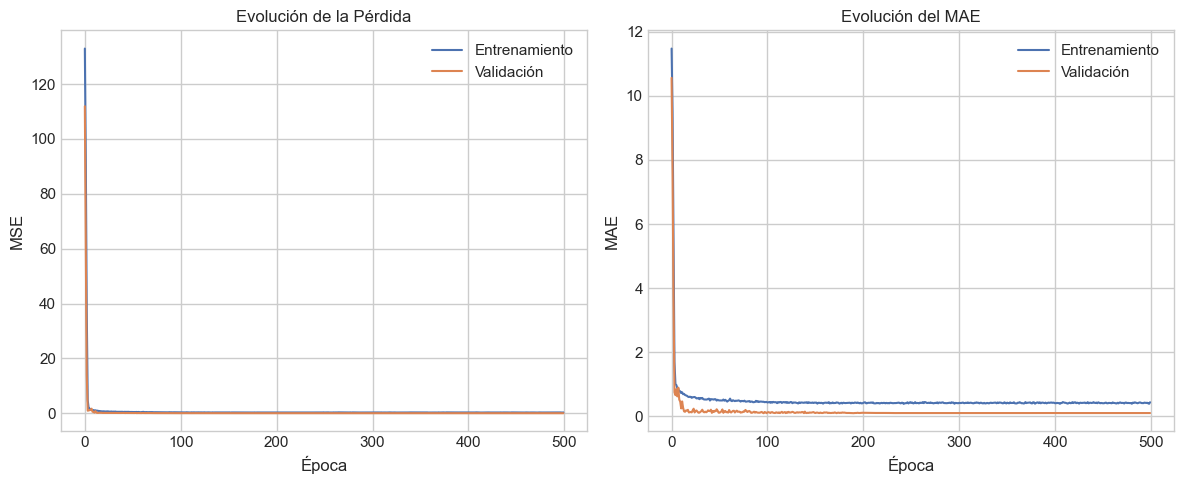

In [64]:


# %% [code]
# === PASO 6: ENTRENAMIENTO CON CALLBACKS ===

callbacks = [
    # EarlyStopping(patience=30, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=10)
]

history = model.fit(
    X_train_selected, y_train,
    validation_data=(X_val_selected, y_val),
    epochs=500,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Visualización del entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la Pérdida')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Evolución del MAE')
plt.ylabel('MAE')
plt.xlabel('Época')
plt.legend()
plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Métricas Finales:
MAE: 18118.7172695491
RMSE: 30307.925665003597
R²: 0.8868556008391077
RMSE (%): 16.80%

Tabla Comparativa (Primeras Filas):
   Precio Real (USD)  Precio Predicho (USD)  Error Absoluto (USD)
0           154500.0          152504.593750           1995.406250
1           325000.0          298382.375000          26617.625000
2           115000.0          117987.992188           2987.992188
3           159000.0          170822.734375          11822.734375
4           315500.0          290223.812500          25276.187500
5            75500.0           83302.195312           7802.195312
6           311500.0          221946.453125          89553.546875
7           146000.0          157994.015625          11994.015625
8            84500.0           80402.203125           4097.796875
9           135500.0          143448.078125           7948.078125


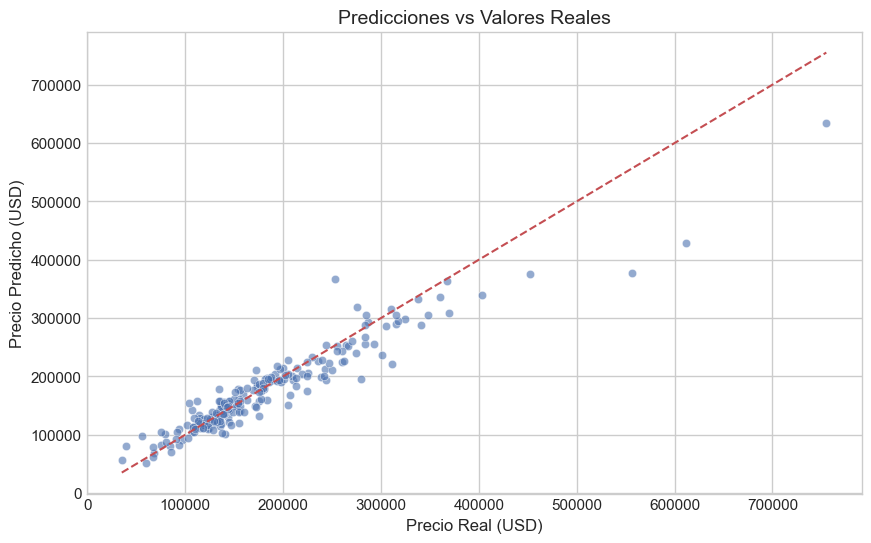

In [65]:
# === PASO 7: EVALUACIÓN FINAL ===

best_model = tf.keras.models.load_model('best_model.h5', compile=False)

# Predicciones y transformación inversa
y_pred = best_model.predict(X_test_selected)
y_test_exp = np.expm1(y_test)  # Transformación inversa de los valores reales
y_pred_exp = np.expm1(y_pred).flatten()  # Transformación inversa de las predicciones

# Cálculo del RMSE en porcentaje
rmsep = ((np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))) / y_test_exp.mean()) * 100

# Métricas finales
metrics = {
    'MAE': mean_absolute_error(y_test_exp, y_pred_exp),
    'RMSE': np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)),
    'R²': r2_score(y_test_exp, y_pred_exp),
    'RMSE (%)': f"{rmsep:.2f}%"  # Conversión a cadena con formato
}

print("\nMétricas Finales:")
for k, v in metrics.items():
    print(f"{k}: {v}")

# Crear una tabla comparativa entre valores reales y predichos
comparison_df = pd.DataFrame({
    'Precio Real (USD)': y_test_exp,
    'Precio Predicho (USD)': y_pred_exp,
    'Error Absoluto (USD)': np.abs(y_test_exp - y_pred_exp)
}).reset_index(drop=True)

print("\nTabla Comparativa (Primeras Filas):")
print(comparison_df.head(10))  # Mostrar las primeras 10 filas para comparación

# Gráfico de predicciones vs reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_exp, y=y_pred_exp, alpha=0.6)
plt.plot([y_test_exp.min(), y_test_exp.max()], 
         [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.title('Predicciones vs Valores Reales', fontsize=14)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True)
plt.show()


In [66]:
import joblib

# Ajustas tu preprocessor y selector con X_train
# ...
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(selector, 'selector.joblib')


['selector.joblib']

In [67]:
preprocessor = joblib.load('preprocessor.joblib')
selector = joblib.load('selector.joblib')


In [68]:
import joblib

# Supongamos que 'preprocessor' y 'selector' ya fueron ajustados en X_train
# Guardamos ambos objetos
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(selector, 'selector.joblib')

# Guardamos X_test, y_test para usarlos en el servidor
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)


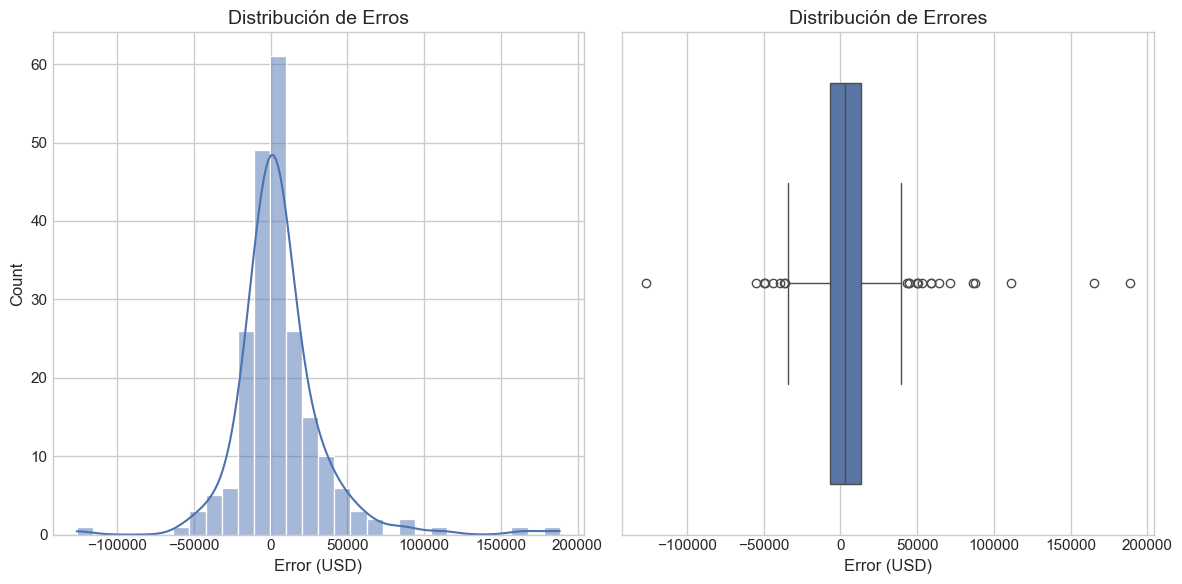

In [55]:


# %% [code]
# === PASO 8: ANÁLISIS DE ERRORES ===

errors = y_test_exp - y_pred_exp
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribución de Erros', fontsize=14)
plt.xlabel('Error (USD)')

plt.subplot(1, 2, 2)
sns.boxplot(x=errors)
plt.title('Distribución de Errores', fontsize=14)
plt.xlabel('Error (USD)')

plt.tight_layout()
plt.show()


In [73]:


# %% [code]
# === PASO 9: GUARDADO DEL MODELO ===

# Guardamos todos los componentes necesarios
model_artifacts = {
    'preprocessor': preprocessor,
    'selector': selector,
    'model': best_model,
    'features': all_features,
    'selected_features_mask': selector.get_support()
}

joblib.dump(model_artifacts, 'final_model_package.pkl')

# Función de predicción de ejemplo
def predict_price(new_data, model_package):
    processed_data = model_package['preprocessor'].transform(new_data)
    selected_data = model_package['selector'].transform(processed_data)
    prediction_log = model_package['model'].predict(selected_data)
    return np.expm1(prediction_log).flatten()[0]

# Ejemplo de uso
sample_data = X_test.iloc[[0]]
print("\nPredicción de ejemplo:")
print(f"Valor Real: ${np.expm1(y_test.iloc[0]):,.2f}")
print(f"Predicción: ${predict_price(sample_data, model_artifacts):,.2f}")




Predicción de ejemplo:
Valor Real: $154,500.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicción: $152,504.45
